<a href="https://colab.research.google.com/github/hurtadosanti/TrafficSignClassifier/blob/master/TrafficSignClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import pickle
import os
from zipfile import ZipFile
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
%matplotlib inline
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Load Data

In [3]:
path = '/tmp/'
traffic_signs_file = 'traffic-signs-data.zip'
!wget --no-check-certificate \
    https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip \
    -O /tmp/traffic-signs-data.zip

!wget --no-check-certificate \
    https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/master/signnames.csv

with ZipFile(path+traffic_signs_file, 'r') as zipObj:
   zipObj.extractall(path)
   print('Finish extracting')

--2020-09-24 04:39:53--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.224
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘/tmp/traffic-signs-data.zip’

/tmp/traffic-signs- 100%[===================>] 117.80M  20.0MB/s    in 6.8s    

2020-09-24 04:40:00 (17.4 MB/s) - ‘/tmp/traffic-signs-data.zip’ saved [123524425/123524425]

--2020-09-24 04:40:00--  https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [4]:
train = pickle.load(open(path+"train.p", 'rb'))
valid=pickle.load(open(path+"valid.p", 'rb'))
test = pickle.load(open(path+"test.p", 'rb'))
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Data description

In [8]:
# Verify that the data is complete
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))
# Data Size
print('Training set samples',len(X_train))
print('Validation set samples',len(X_valid))
print('Test set samples',len(X_test))
# Sign names labels
sign_names = pd.read_csv('signnames.csv')
print(sign_names.head())
sign_names.describe()

Training set samples 34799
Validation set samples 4410
Test set samples 12630
   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


,ClassId
count,43.000000
mean,21.000000
std,12.556539
min,0.000000
25%,10.500000
50%,21.000000
75%,31.500000
max,42.000000


## Data distribution

                  0
count  12630.000000
mean      15.551069
std       11.947123
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000


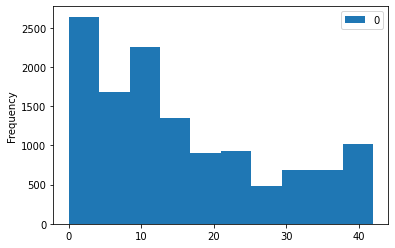

In [9]:
# Describe test Y data
df_y_test = pd.DataFrame(y_test)
print(df_y_test.describe())
df_y_test.plot.hist()

## Data Random Samples

In [ ]:
# Random signs from the Y data
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i in results[:10]:
    sign_index = y_train[i]
    print(i,sign_index,sign_names.at[sign_index,'SignName'])

In [ ]:
# Random signs images and the correspondent name
fig, axes = plt.subplots(5,5, figsize=(15,15))
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i,ax in  enumerate(axes.flat):
    pos = results[i]
    sign_index = y_train[pos]
    ax.set_title(sign_names.at[sign_index,'SignName'],fontsize=10)
    ax.imshow(X_train[pos])
    ax.set_axis_off()

## Data preprocessing

In [10]:
from sklearn.utils import shuffle
X_train = np.sum(X_train/3, axis=3, keepdims=True)/255.0
X_valid = np.sum(X_valid/3, axis=3, keepdims=True)/255.0
X_train, y_train = shuffle(X_train, y_train)

## Training

In [34]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
def LeNet(x,dropout):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    # Convolution 1 and max_pool
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv1.shape)

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    # Convolution 2 and max_pool
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    print(conv2.shape)
    # Flatten last convolution
    fc0   = flatten(conv2)
    print(fc0.shape)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(1152, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    fc1   = tf.nn.dropout(fc1, dropout)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 42), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(42))
    #print(fc1.shape,fc2_W.shape,fc2_b.shape)
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 42)
rate = 0.0007
dropout = 0.5
logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 16, 16, 16)
(?, 6, 6, 32)
(?, 1152)


In [35]:
BATCH_SIZE=128
EPOCHS=15

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                           y: batch_y,
                                                           keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x,
                                                    y: batch_y,
                                                    keep_prob: dropout})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.602

EPOCH 2 ...
Validation Accuracy = 0.808

EPOCH 3 ...
Validation Accuracy = 0.852

EPOCH 4 ...
Validation Accuracy = 0.877

EPOCH 5 ...
Validation Accuracy = 0.893

EPOCH 6 ...
Validation Accuracy = 0.896

EPOCH 7 ...
Validation Accuracy = 0.920

EPOCH 8 ...
Validation Accuracy = 0.920

EPOCH 9 ...
Validation Accuracy = 0.918

EPOCH 10 ...
Validation Accuracy = 0.916

EPOCH 11 ...
Validation Accuracy = 0.906

EPOCH 12 ...
Validation Accuracy = 0.890

EPOCH 13 ...
Validation Accuracy = 0.884

EPOCH 14 ...
Validation Accuracy = 0.866

EPOCH 15 ...
Validation Accuracy = 0.745

Model saved
